# Data Preparation for modelling :

In [ ]:
#!unzip '/content/drive/My Drive/Colab Notebooks/NLMCXR_png.zip' -d '/content'

In [2]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import re
import seaborn as sns
#from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/preprocessed_data.csv')

# Images with No information :

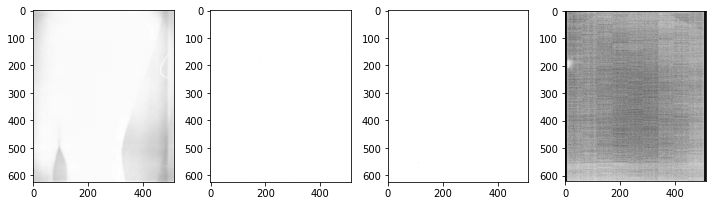

In [4]:
outliers = ['CXR2560_IM-1064-4001.png','CXR2084_IM-0715-2001-0001.png','CXR2084_IM-0715-1001-0002.png','CXR3809_IM-1919-1003002.png']
fig, axs = plt.subplots(1, len(outliers), figsize = (10,10), tight_layout=True)
i = 0
for img, subplot in zip(outliers, axs.flatten()):
    filename = '/content/NLMCXR_png/' + img
    image = cv2.imread(filename)
    imgplot = axs[i].imshow(image)
    i += 1

In [6]:
df = df.dropna() # removing abnormal images
df.shape

(7466, 6)

# Creating Dataset :
* patients with four images :
    1. frontal1,lateral1 >> output
    2. frontal1,lateral2 >> output
    3. frontal2,lateral1 >> output
    4. frontal2,lateral2 >> output
* patients with three images :
    1. frontal1,lateral1 >> output
    2. frontal1,lateral2 >> output
* patients with one image :
    1. frontal1,frontal1 >> output
    2. lateral1,lateral1 >> output

  

# Creating frontal dataframe :

In [7]:
frontal_df = df[df['projection'] == 'Frontal']
frontal_df.head()

,image_id,indication,findings,impression,image_grp,projection
0,CXR594_IM-2187-1001.png,pain weakness,there are t spine osteophytes there calcified ...,borderline cardiomegaly age indeterminate chro...,CXR594_IM_2187,Frontal
2,CXR532_IM-2140-1001.png,woman vehicle collision,the lungs are clear bilaterally specifically n...,no acute cardiopulmonary abnormality,CXR532_IM_2140,Frontal
5,CXR541_IM-2147-1001.png,chest pain,cardiomediastinal contour and pulmonary vascul...,no acute cardiopulmonary findings age indeterm...,CXR541_IM_2147,Frontal
7,CXR569_IM-2169-0001-0002.png,rule out aspiration,the heart size and pulmonary vascularity appea...,continued elevation of the left hemidiaphragm ...,CXR569_IM_2169_0001,Frontal
8,CXR581_IM-2178-1001.png,dyspnea asthma,frontal and lateral views of the chest show an...,no acute or active cardiac pulmonary or pleura...,CXR581_IM_2178,Frontal


# Creating Lateral dataframe :

In [8]:
lateral_df = df[df['projection']== 'Lateral']
lateral_df.head()

,image_id,indication,findings,impression,image_grp,projection
1,CXR594_IM-2187-2001.png,pain weakness,there are t spine osteophytes there calcified ...,borderline cardiomegaly age indeterminate chro...,CXR594_IM_2187,Lateral
3,CXR532_IM-2140-2001.png,woman vehicle collision,the lungs are clear bilaterally specifically n...,no acute cardiopulmonary abnormality,CXR532_IM_2140,Lateral
4,CXR526_IM-2137-1002.png,preop for left hip revision,no findings,minimal cardiomegaly lungs are clear fat seen ...,CXR526_IM_2137,Lateral
6,CXR569_IM-2169-0001-0001.png,rule out aspiration,the heart size and pulmonary vascularity appea...,continued elevation of the left hemidiaphragm ...,CXR569_IM_2169_0001,Lateral
9,CXR581_IM-2178-3001.png,dyspnea asthma,frontal and lateral views of the chest show an...,no acute or active cardiac pulmonary or pleura...,CXR581_IM_2178,Lateral


In [25]:
image_list = []
for i,ind in zip(frontal_df['image_grp'],frontal_df['image_grp'].index) :
  k = lateral_df[lateral_df['image_grp'] == i]['image_id'].values
  for j in range(len(k)) :
    L = []
    L.append(frontal_df['image_id'][ind])
    L.append(k[j])
    L.append(frontal_df['indication'][ind])
    L.append(frontal_df['findings'][ind])
    L.append(frontal_df['impression'][ind])
    image_list.append(L)
  if len(k) == 0 :
    L = []
    L.append(frontal_df['image_id'][ind])
    L.append(frontal_df['image_id'][ind])
    L.append(frontal_df['indication'][ind])
    L.append(frontal_df['findings'][ind])
    L.append(frontal_df['impression'][ind])
    image_list.append(L)



In [26]:
new_df = pd.DataFrame(image_list,columns=['Frontal','Lateral','indication','findings','impression'])

In [28]:
image_per_patient = df.groupby('image_grp')['image_id'].nunique()
image_per_patient.columns = ['count']
c = pd.DataFrame(columns=['image_grp','count'])
c['image_grp'] = image_per_patient.keys()
c['count'] = image_per_patient.values

In [30]:
r = c[c['count'] == 1]['image_grp'].values

In [32]:
len(r)

459

In [42]:
image_list1 = []
for i in r :
  k = lateral_df[lateral_df['image_grp'] == i]['image_id'].values
  ind = lateral_df[lateral_df['image_grp'] == i]['image_id'].index
  if len(k) != 0 :
    L = []
    L.append(lateral_df['image_id'][ind].values[0])
    L.append(lateral_df['image_id'][ind].values[0])
    L.append(lateral_df['indication'][ind].values[0])
    L.append(lateral_df['findings'][ind].values[0])
    L.append(lateral_df['impression'][ind].values[0])
    image_list1.append(L)


In [43]:
len(image_list1)

161

In [44]:
df1 = pd.DataFrame(image_list1,columns=['Frontal','Lateral','indication','findings','impression'])

In [46]:
new_df = pd.concat([new_df,df1], axis=0)

In [47]:
new_df

,Frontal,Lateral,indication,findings,impression
0,CXR594_IM-2187-1001.png,CXR594_IM-2187-2001.png,pain weakness,there are t spine osteophytes there calcified ...,borderline cardiomegaly age indeterminate chro...
1,CXR532_IM-2140-1001.png,CXR532_IM-2140-2001.png,woman vehicle collision,the lungs are clear bilaterally specifically n...,no acute cardiopulmonary abnormality
2,CXR541_IM-2147-1001.png,CXR541_IM-2147-1001.png,chest pain,cardiomediastinal contour and pulmonary vascul...,no acute cardiopulmonary findings age indeterm...
3,CXR569_IM-2169-0001-0002.png,CXR569_IM-2169-0001-0001.png,rule out aspiration,the heart size and pulmonary vascularity appea...,continued elevation of the left hemidiaphragm ...
4,CXR581_IM-2178-1001.png,CXR581_IM-2178-3001.png,dyspnea asthma,frontal and lateral views of the chest show an...,no acute or active cardiac pulmonary or pleura...
...,...,...,...,...,...
156,CXR885_IM-2399-2001.png,CXR885_IM-2399-2001.png,with ongoing shortness of breath and history o...,heart size mediastinal contour and pulmonary v...,no acute cardiopulmonary abnormality postsurgi...
157,CXR88_IM-2394-2001.png,CXR88_IM-2394-2001.png,worsening dyspnea history of coronary artery d...,heart is mildly heart enlarged mediastinal con...,findings consistent with mild congestive heart...
158,CXR900_IM-2408-2001.png,CXR900_IM-2408-2001.png,allogeneic bmt w u lab,the heart is normal in size the mediastinum is...,no acute disease
159,CXR904_IM-2409-3003.png,CXR904_IM-2409-3003.png,painful chest,normal heart size left chest tip mid svc right...,stable appearance of the chest no or acute fin...


In [49]:
new_df.to_csv("/content/drive/My Drive/Colab Notebooks/preprocessed_data.csv", index=False)